In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### ANALYSIS STRUCTURE

1. Data preparation

2. Data visualization

    2.1. Parking-time pattern
    * Arrival distribution by hour
    * Depature distribution by hour
    * Overnight charging
    * Dwell time statistics
    * Idle time ratio
    
    2.2. Energy-related pattern
    * Energy requirement range
        * ! Testing hypothesis: Do EV users have the knowledge about the charge duration needed to meet their energy need?
        * ! Calculate the correlation between required energy and expected dwell time?
    * Energy delivered histogram
    * Fulfillment rate


### CHARING BEHAVIOR INSIGHTS

#### Arrival pattern
* Almost no EV arrives at the campus until 10:00 of the day
* From 27-28 Dec 2018, 94% of the cars arrived after 10:00. 72% of them arrived between 14PM and 18PM. On 28th Dec (Friday), almost no cars arrive before 14:00

#### Departure pattern
* 88% of EV users departed after 19:00 or before 4:00. With that being said, almost no depatures reported from 4:00 to 19:00

#### Overnight charging
* ~ 30% of charging sessions were overnight charging, equivalent to 20/68 sessions. 
* All overnight charging cars arrived after 13:00 and stayed around 3 to 12 hours in the charging station

#### Dwell time
* EVs stayed connected with EVSE 6 hours on averge, the longest duration reported was nearly 12 hours. 
* 75% of the cars stayed less than 8.5 hours

#### Charge length
* On average, most charging sessions lasted 4 hours, meaning charging stopped, however it is not an indidator that the energy need is fully satisfied. 
* 75% of the charging sessions stopped after 5.5 hours of staying plug-in

#### Idle time

**Case 1.** **Charging stops prior to depature, demand fulfilled** - *load shifting potential*


   * Around 10% fo the cars had the potential for load shifting (cases where cars' demand is fulfilled while the duration spent without charging > 30 mins )
   * The average idle duration of the flexible load group is 1.5 hours
   

**Case 2.** **Charging stops prior to depature, demand unmet** -  *require further investigation*

   * Around 52% of the total sessions stoped prior to departure while their energy demand had not been met.
   * The average idle duration of this group is 4 hours


**Case 3.**  **Charging stops upon departure** -  *no load shifting potential*

   * 38% of charging stoped upon departure
   * 75% of these cases have their energy demand unmet.
   * Possible reasons include abrupt departures to free up charging spots due to limited space at the station, or users lacking knowledge of required charge duration relative to their dwell time
   * These cases are not subject to optimization as there's no room to shift the demand load. 

#### Required & delivered energy 

* The energy requirement varies between 6 to 77 kWh. 50% of the cars requested less than 20kWh.
* The amount of energy succesfully delivered to EVs varies between 3 to 56 kWh. Half of the total session supplied less than 11kWh.

* On average, EVs were charged upto 60% of their requirement. 17% of the cars were charged over 90% of the demand.

   
   


### Data preparation

In [2]:
# Define the path to your JSON file
json_path = r'G:\My Drive\2. OVGU\5th semester\Thesis\Data\ACN-Data\JPL 27-28Dec.json'

# Load JSON data into a DataFrame
with open(json_path, 'r') as json_file:
    data = json.load(json_file)

# Convert JSON data to DataFrame
df = pd.json_normalize(data['_items'])

# List of columns to keep
selected_columns = ['sessionID', 'connectionTime', 'disconnectTime','doneChargingTime', 'kWhDelivered']

# Keep only the specified columns
session_df = df[selected_columns]

#Flatten user inputs field
user_inputs_df = pd.json_normalize(df['userInputs'])
user_inputs_df = pd.json_normalize(user_inputs_df[0])

#Keeping data field needed
selected_columns2 = ['kWhRequested','requestedDeparture']
user_inputs_df = user_inputs_df[selected_columns2]

# Concatenate the two DataFrames
final_df = pd.concat([session_df, user_inputs_df], axis=1)


In [3]:
# Convert to datetime data type
final_df['connectionTime'] = pd.to_datetime(final_df['connectionTime'])
final_df['disconnectTime'] = pd.to_datetime(final_df['disconnectTime'])
final_df['doneChargingTime'] = pd.to_datetime(final_df['doneChargingTime'])
final_df['requestedDeparture'] = pd.to_datetime(final_df['requestedDeparture'])

In [4]:
# Rename final_df 
final_df.rename(columns={
    'connectionTime': 'arrival',
    'disconnectTime': 'departure',
    'doneChargingTime': 'done time',
    'kWhDelivered': 'delivered energy',
    'kWhRequested': 'required energy'
}, inplace=True)



In [5]:
# Subset data cover charging session that initated from 27th to 28th Dec
subset_data = final_df[
    (final_df['arrival'].dt.date == pd.Timestamp('2018-12-27')) |
    (final_df['arrival'].dt.date == pd.Timestamp('2018-12-28'))
]
total_cars = len(subset_data)

### DATA VISUALIZATION
### Arrival distribution by time

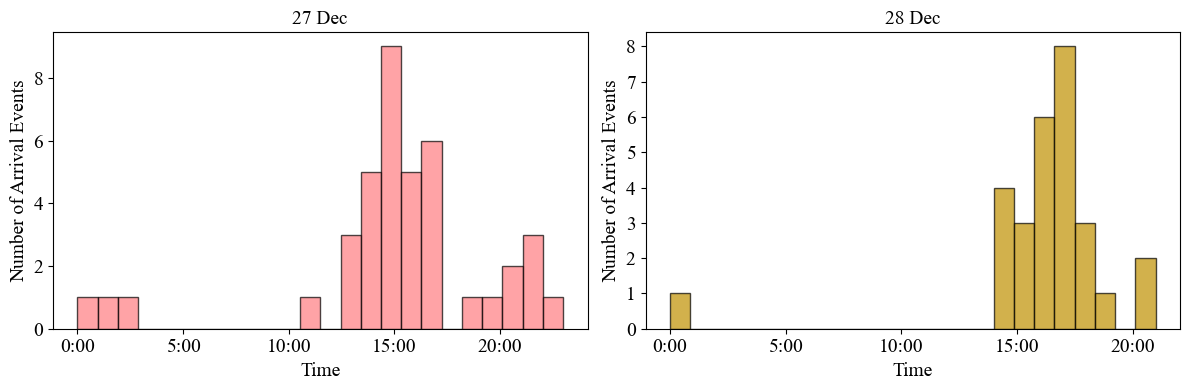

In [6]:

# Convert arrival and departure columns to datetime
subset_data['arrival'] = pd.to_datetime(subset_data['arrival'])
subset_data['departure'] = pd.to_datetime(subset_data['departure'])

# Filter rows for 27th and 28th December
subset_27th = subset_data[subset_data['arrival'].dt.date == pd.Timestamp('2018-12-27')]
subset_28th = subset_data[subset_data['arrival'].dt.date == pd.Timestamp('2018-12-28')]

plt.figure(figsize=(12, 4))

font = {'fontname': 'Times New Roman', 'size': 14}

# Plot arrival distribution for 27th December
plt.subplot(1, 2, 1)
plt.hist(subset_27th['arrival'].dt.hour, bins=24, color='#FF7C80', edgecolor='black', alpha=0.7)
plt.xlabel('Time', **font)
plt.ylabel('Number of Arrival Events', **font)
plt.title('27 Dec', **font)
plt.xticks(range(0, 24, 5), [f'{hour}:00' for hour in range(0, 24, 5)], **font)
plt.yticks(**font)

# Plot arrival distribution for 28th December
plt.subplot(1, 2, 2)
plt.hist(subset_28th['arrival'].dt.hour, bins=24, color='#BF9000', edgecolor='black', alpha=0.7)
plt.xlabel('Time', **font)
plt.ylabel('Number of Arrival Events', **font)
plt.title('28 Dec', **font)
plt.xticks(range(0, 24, 5), [f'{hour}:00' for hour in range(0, 24, 5)], **font)
plt.yticks(**font)

# Adjust layout with more space at the bottom
plt.subplots_adjust(bottom=0.2)

# Save plot as png image
plt.savefig('plugin_distribution.png', dpi=600)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# % of cars arrive after 10AM
print("% car arrive after 10AM is ",len(subset_data[subset_data['arrival'].dt.hour >=10])/len(subset_data)*100,"%")
print("% car arrive between 14PM to 18PM is ",len(subset_data[(subset_data['arrival'].dt.hour >= 14) & (subset_data['arrival'].dt.hour <= 18)]) / len(subset_data)*100,"%")

% car arrive after 10AM is  94.11764705882352 %
% car arrive between 14PM to 18PM is  72.05882352941177 %


### Departure distribution by time

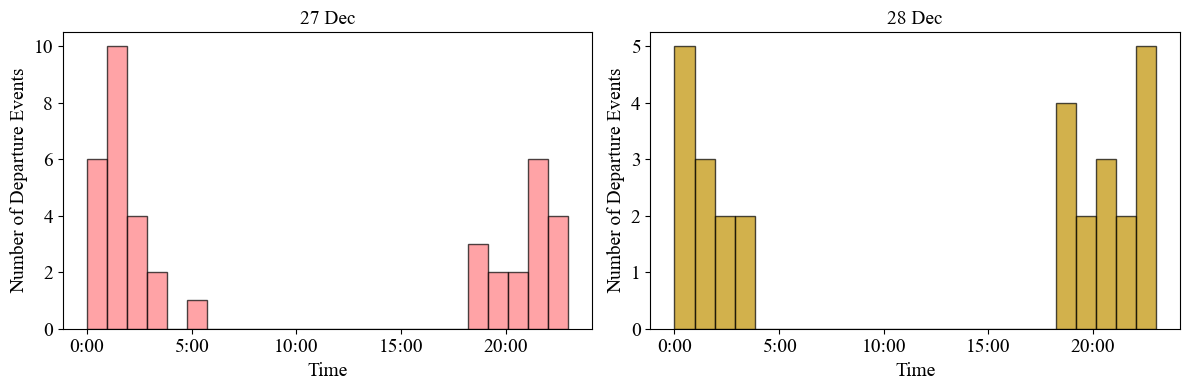

In [8]:
# Convert arrival and departure columns to datetime
subset_data['arrival'] = pd.to_datetime(subset_data['arrival'])
subset_data['departure'] = pd.to_datetime(subset_data['departure'])

# Filter rows for 27th and 28th December
subset_27th = subset_data[subset_data['arrival'].dt.date == pd.Timestamp('2018-12-27')]
subset_28th = subset_data[subset_data['arrival'].dt.date == pd.Timestamp('2018-12-28')]

plt.figure(figsize=(12, 4))

font = {'fontname': 'Times New Roman', 'size': 14}

# Plot arrival distribution for 27th December
plt.subplot(1, 2, 1)
plt.hist(subset_27th['departure'].dt.hour, bins=24, color='#FF7C80', edgecolor='black', alpha=0.7)
plt.xlabel('Time', **font)
plt.ylabel('Number of Departure Events', **font)
plt.title('27 Dec', **font)
plt.xticks(range(0, 24, 5), [f'{hour}:00' for hour in range(0, 24, 5)], **font)
plt.yticks(**font)

# Plot arrival distribution for 28th December
plt.subplot(1, 2, 2)
plt.hist(subset_28th['departure'].dt.hour, bins=24, color='#BF9000', edgecolor='black', alpha=0.7)
plt.xlabel('Time', **font)
plt.ylabel('Number of Departure Events', **font)
plt.title('28 Dec', **font)
plt.xticks(range(0, 24, 5), [f'{hour}:00' for hour in range(0, 24, 5)], **font)
plt.yticks(**font)

# Adjust layout with more space at the bottom
plt.subplots_adjust(bottom=0.2)

# Save plot as png image
plt.savefig('unplug_distribution.png', dpi=600)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
percentage_depart_after_19_before_4 = len(subset_data[((subset_data['departure'].dt.hour > 19) | (subset_data['departure'].dt.hour < 4))]) / len(subset_data) * 100

print("Percentage of Cars Departing After 19:00 or Before 4:00:", percentage_depart_after_19_before_4)

Percentage of Cars Departing After 19:00 or Before 4:00: 88.23529411764706


### Overnight charging

In [10]:
# Calculate the dwell time (duration) of each session in hours
subset_data['dwell time'] = (subset_data['departure'] - subset_data['arrival']).dt.total_seconds() / 3600

# Filter rows where cars arrive on 27th and depart on 28th
overnight_charging_data = subset_data[(subset_data['arrival'].dt.date == pd.Timestamp('2018-12-27')) & 
                                      (subset_data['departure'].dt.date == pd.Timestamp('2018-12-28'))]
# Calculate the number and percentage of overnight charging sessions
num_overnight_charging = len(overnight_charging_data)
percentage_overnight_charging = (num_overnight_charging / len(subset_data)) * 100

print("Number of Overnight Charging Sessions:", num_overnight_charging)
print("Percentage of Overnight Charging Sessions:", percentage_overnight_charging)

# What time did overnight charging cars start charging?
print(overnight_charging_data['arrival'].dt.time)


Number of Overnight Charging Sessions: 20
Percentage of Overnight Charging Sessions: 29.411764705882355
32    13:19:15
35    14:25:45
37    14:35:46
39    14:57:18
41    15:24:17
45    15:40:08
47    15:44:46
48    15:58:27
49    16:05:56
53    16:52:41
54    17:07:21
55    17:08:49
58    17:43:08
60    19:21:26
61    20:19:59
63    21:29:40
64    22:02:31
65    22:07:16
66    22:37:00
67    23:40:34
Name: arrival, dtype: object


In [11]:
# How long did overnight charging cars stayed in the charging stations?
print(overnight_charging_data['dwell time'].describe()) 

count    20.000000
mean      7.594000
std       2.803163
min       2.468333
25%       5.018889
50%       8.573750
75%       9.560069
max      11.884444
Name: dwell time, dtype: float64


### Dwell time and Charging length statistics

In [12]:
# Generate charge length values
subset_data['charge length'] = (subset_data['done time'] - subset_data['arrival']).dt.total_seconds() / 3600

In [13]:
# Basic statistics about dwell time
subset_data['dwell time'].describe()

count    68.000000
mean      6.288145
std       2.853490
min       0.588056
25%       3.708264
50%       6.851389
75%       8.562639
max      11.884444
Name: dwell time, dtype: float64

In [14]:
# Basic statistics about charge length 
subset_data['charge length'].describe()

count    68.000000
mean      4.068750
std       2.495166
min       0.586667
25%       2.184444
50%       3.514722
75%       5.352083
max      11.883333
Name: charge length, dtype: float64

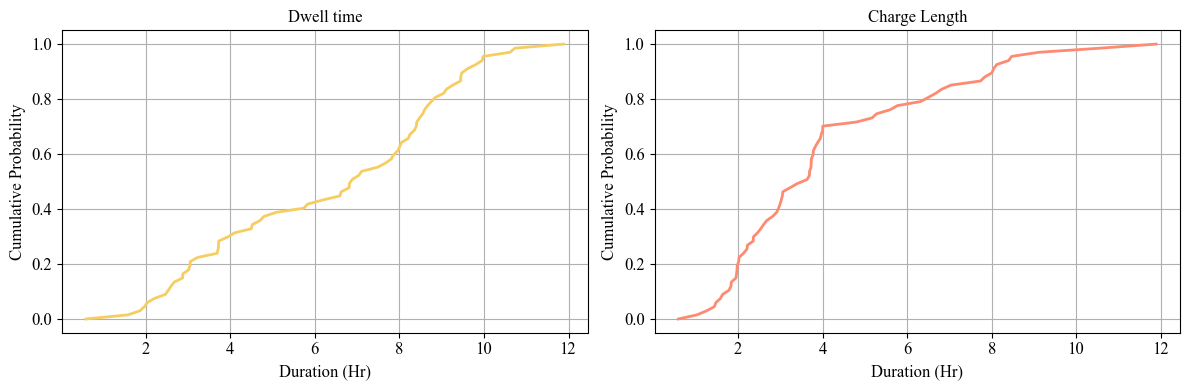

In [15]:

dwell_time_cumulative = np.sort(subset_data['dwell time'])
charge_length_cumulative = np.sort(subset_data['charge length'])

plt.figure(figsize=(12, 4))

font = {'fontname': 'Times New Roman', 'size': 12}

# Create a cumulative distribution plot for dwell time
plt.subplot(1, 2, 1)
plt.plot(dwell_time_cumulative, np.linspace(0, 1, len(dwell_time_cumulative)), color='#f6cd61', linewidth=2)
plt.xlabel('Duration (Hr)', **font)
plt.ylabel('Cumulative Probability', **font)
plt.title('Dwell time', **font)
plt.xticks(**font)
plt.yticks(**font)
plt.grid(True)

# Create a cumulative distribution plot for charge length
plt.subplot(1, 2, 2)
plt.plot(charge_length_cumulative, np.linspace(0, 1, len(charge_length_cumulative)), color='#fe8a71', linewidth=2)
plt.xlabel('Duration (Hr)', **font)
plt.ylabel('Cumulative Probability', **font)
plt.title('Charge Length', **font)
plt.xticks(**font)
plt.yticks(**font)
plt.grid(True)

# Save plot as a PNG image
plt.savefig('dwell_charge_length_cumulative_distribution.png', dpi=600)

# Adjust layout
plt.tight_layout()
plt.show()

### Idle time statistics

In [16]:
# Calculate idle time
subset_data['Idle duration'] = (subset_data['departure']-subset_data['done time']).dt.total_seconds() / 3600

# Calculate idle time ratio
subset_data['Idle ratio'] = subset_data['Idle duration']/subset_data['dwell time']


28    0.545400
29    0.423792
30    0.164229
31    0.558941
32    0.553543
        ...   
91    0.651111
92    0.472667
93    0.082749
94    0.461181
95    0.548467
Name: Fulfillment rate, Length: 68, dtype: float64


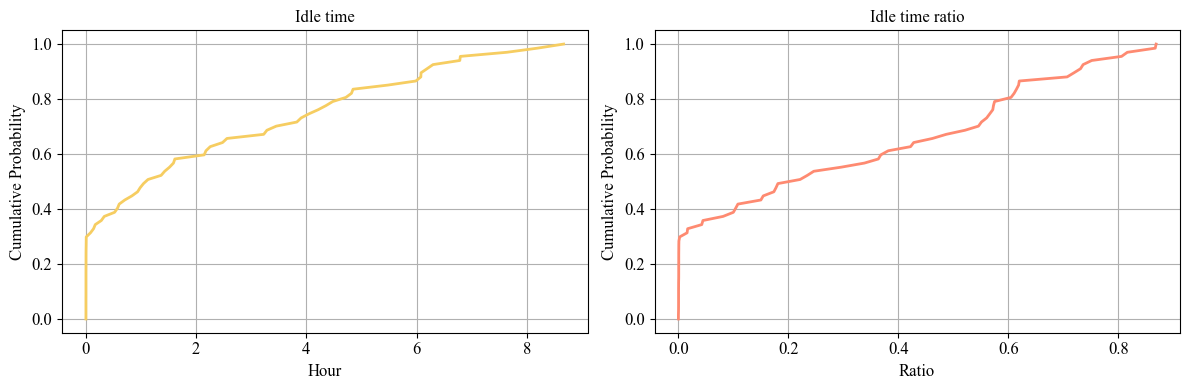

In [24]:
idle_dur_cumulative = np.sort(subset_data['Idle duration'])
idle_ratio_cumulative = np.sort(subset_data['Idle ratio'])

plt.figure(figsize=(12, 4))

font = {'fontname': 'Times New Roman', 'size': 12}

# Create a cumulative distribution plot for idle duration
plt.subplot(1, 2, 1)
plt.plot(idle_dur_cumulative, np.linspace(0, 1, len(idle_dur_cumulative)), color='#f6cd61', linewidth=2)
plt.xlabel('Hour', **font)
plt.ylabel('Cumulative Probability', **font)
plt.title('Idle time', **font)
plt.xticks(**font)
plt.yticks(**font)
plt.grid(True)

# Create a cumulative distribution plot for idle time ratio
plt.subplot(1, 2, 2)
plt.plot(idle_ratio_cumulative, np.linspace(0, 1, len(idle_ratio_cumulative)), color='#fe8a71', linewidth=2)
plt.xlabel('Ratio', **font)
plt.ylabel('Cumulative Probability', **font)
plt.title('Idle time ratio', **font)
plt.xticks(**font)
plt.yticks(**font)
plt.grid(True)

# Save plot as a PNG image
plt.savefig('Idle_cumulative_distribution.png', dpi=600)

# Adjust layout
plt.tight_layout()
plt.show()

### Identfy flexible load group

In [25]:
# Case 1: Charging stops before departure, demand fulfilled

## Extract the number of cases that idle duration >= 0.5 and fulfillment rate > 90%

stop_prior_depart = subset_data[subset_data['Idle duration']>=0.5]
stop_prior_depart_demand_met = stop_prior_depart[stop_prior_depart['Fulfillment rate']>= 0.9]

print("The number of cars with flexible load is:", len(stop_prior_depart_demand_met),
     "corresponding to",(len(stop_prior_depart_demand_met)/total_cars*100),"%")

aver_idle_flexible_group = stop_prior_depart_demand_met['Idle duration'].mean()
aver_idle_ratio_flex_group = stop_prior_depart_demand_met['Idle ratio'].mean()
print("The average idle duration of the flexible load group is", aver_idle_flexible_group)
print("The average idle ratio of the flexible load group is", aver_idle_ratio_flex_group)



The number of cars with flexible load is: 7 corresponding to 10.294117647058822 %
The average idle duration of the flexible load group is 1.480357142857143
The average idle ratio of the flexible load group is 0.17954775655183575


In [26]:
# Case 2: Charging stops before departure, demand unmet
stop_prior_depart_demand_unmet = stop_prior_depart[stop_prior_depart['Fulfillment rate']< 0.9]
                             
print("The number of charging stops before departure while demand is unmet is", len(stop_prior_depart_demand_unmet),
      "corresponding to",(len(stop_prior_depart_demand_unmet)/total_cars*100),"%")

aver_idle_stop_demand_unmet = stop_prior_depart_demand_unmet['Idle duration'].mean()
print("The average idle duration of the ambigous group is", aver_idle_stop_demand_unmet)


The number of charging stops before departure while demand is unmet is 35 corresponding to 51.470588235294116 %
The average idle duration of the ambigous group is 3.9858333333333333


In [27]:
# Case 3: Charging stops upon departure, meaning idle duration < 3 mins

stop_upon_depart = subset_data[subset_data['Idle duration'] < 0.5]

print("The number of charging stop upon departure is:" ,len(stop_upon_depart),
      "corresponding to",(len(stop_upon_depart)*100/total_cars),"%")

aver_idle_stop_upon_depart = stop_upon_depart['Idle duration'].mean()

stop_upon_depart['Fulfillment rate'].describe()
print("The average idle duration of no flexible load is", aver_idle_stop_upon_depart)


The number of charging stop upon departure is: 26 corresponding to 38.23529411764706 %
The average idle duration of no flexible load is 0.04047008547008546


In [28]:

fulfilled_demand_cars = subset_data[subset_data['Fulfillment rate']>=0.9]

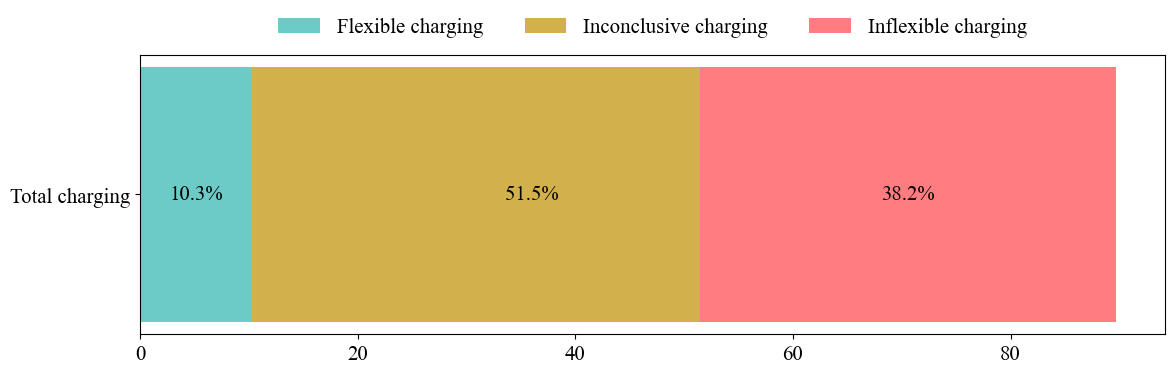

In [29]:
# Set font and font size
font = {'family': 'Times New Roman', 'size': 15}
plt.rc('font', **font)

plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.autolayout"] = True

year = ['Total charging']

flex = len(stop_prior_depart_demand_met) / total_cars * 100
incon = len(stop_prior_depart_demand_unmet) / total_cars * 100
inflex = len(stop_upon_depart) * 100 / total_cars

b1 = plt.barh(year, flex, color='#2FB5B0', alpha = 0.7)
b2 = plt.barh(year, incon, left=flex, color='#BF9000', alpha = 0.7)
b3 = plt.barh(year, inflex, left=incon, color='#FF7C80')

# Show values in the middle of each segment
for bar in b1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.1f}%', va='center', ha='center')

for bar in b2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.1f}%', va='center', ha='center')

for bar in b3:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.1f}%', va='center', ha='center')

# Set the legend on top in 1 row, 3 columns, with no border (frameon=False)
plt.legend([b1, b2, b3], ["Flexible charging", "Inconclusive charging", "Inflexible charging"], 
           loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)

# Remove y-axis label to make the layout cleaner
plt.ylabel(None)

plt.savefig('Charging classification.png', dpi=600)

plt.show()

### Energy related statistics

In [30]:
subset_data['required energy'].describe()

count    68.000000
mean     26.661544
std      19.100446
min       6.660000
25%      13.645000
50%      20.000000
75%      35.920000
max      77.000000
Name: required energy, dtype: float64

In [31]:
subset_data['delivered energy'].describe()

count    68.000000
mean     15.599971
std      13.399711
min       3.018000
25%       7.414500
50%      11.223500
75%      15.052000
max      56.601000
Name: delivered energy, dtype: float64

In [34]:
# Calculate fulfilment rate
subset_data['Fulfillment rate'] = (subset_data['delivered energy']/subset_data['required energy'])
subset_data['Fulfillment rate'].describe()

count    68.000000
mean      0.618163
std       0.257130
min       0.082749
25%       0.462264
50%       0.574325
75%       0.791104
max       1.592700
Name: Fulfillment rate, dtype: float64

In [33]:
fulfilled_demand = subset_data[subset_data['Fulfillment rate']>0.9]
print("The number of session that have their demand fulfilled is",len(fulfilled_demand) )
print("Percentage of sessions that fulfilled charging demand is",len(fulfilled_demand)/total_cars )

The number of session that have their demand fulfilled is 12
Percentage of sessions that fulfilled charging demand is 0.17647058823529413


In [35]:
#Calculated expected dwell time using EV user's input
subset_data['expected dwell'] = (subset_data['requestedDeparture'] - subset_data["arrival"]).dt.seconds / 3600

In [36]:
#! Is expected dwelll time and EV user's required energy has a strong correlation?

correlation = subset_data['expected dwell'].corr(subset_data['required energy'])

print("Correlation:", correlation)

Correlation: 0.29466782074855313


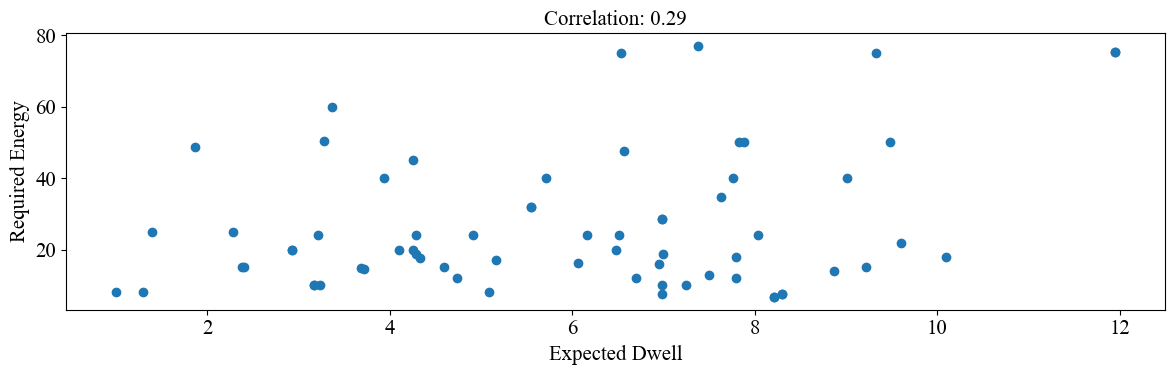

In [41]:
# Assuming subset_data is your DataFrame
correlation = subset_data['expected dwell'].corr(subset_data['required energy'])

font = {'fontname': 'Times New Roman', 'size': 15}
plt.scatter(subset_data['expected dwell'], subset_data['required energy'])
plt.title(f"Correlation: {correlation:.2f}", **font)
plt.xlabel('Expected Dwell', **font)
plt.ylabel('Required Energy', **font)

plt.savefig('Expected dwell vs required energy.png', dpi = 700)
plt.tight_layout()
plt.show()

#### Extract data a